In [ ]:
import pip
def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])  

import_or_install('owslib')
import_or_install('rasterio')
import_or_install('fiona')
import_or_install('geopandas')

import owslib
from owslib.wms import WebMapService 
import rasterio
from rasterio.plot import show
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint
import rasterio.mask
from google.colab import files
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling, calculate_default_transform
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from rasterio.plot import show
from rasterio.enums import MergeAlg
import rasterio.plot



In [ ]:
######GET RGB IMAGE 7.5CM RES######

#paste here the url to the web map service
Url_To_RGB='https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0?request=GetCapabilities&service=wms'
wms = WebMapService(Url_To_RGB)

#list of all maps in the web map service
list(wms.contents)

#check the metadata of the layer
print(wms['Actueel_orthoHR'].abstract)
# wms['Actueel_orthoHR'].title
# wms['Actueel_orthoHR'].queryable
# wms['Actueel_orthoHR'].opaque
#wms['Actueel_orthoHR'].crsOptions
#wms['Actueel_orthoHR'].styles   #nostyles
print(wms.getOperationByName('GetMap').formatOptions)
#wms['Actueel_orthoHR'].boundingBox   #no bounding
#[op.name for op in wms.operations]  #getcapabilities, getmap, getfeatureinfo


#a boundingbox was drawn using the website: bboxfinder. To get the original resolution, the length and the width of the boundingbox were divided by the amount of pixels per meter.
xsize= (16537 - 16392)*(100/7.5)

ysize= (36870 - 36745)*(100/7.5)
print(xsize)
print(ysize)

#coordinates of the boundingbox
x1=163920
y1=368700
x2=165370
y2=367450

#import the map from the web map service. Unfortunately, for this map only a non georeferenced jpeg image was available. 
img = wms.getmap( layers=['Actueel_orthoHR'],
                  srs='EPSG:28992',
                  bbox=(x1, y2, x2, y1),
                  size=(xsize, ysize),
                  format='image/jpeg',
                  transparent=False)


#save the image
out = open('orthoHR.jpeg', 'wb')
out.write(img.read())
out.close()



Landsdekkende dataset in hoge resolutie kleuren luchtfoto's van de meest recente jaargang.
['image/jpeg']
1933.3333333333335
1666.6666666666667


In [ ]:
######GET INFRARED IMAGE 25CM RES######
#same procedure as for the RGB image
Url_to_infrared= 'https://service.pdok.nl/hwh/luchtfotocir/wms/v1_0?request=GetCapabilities&service=wms'

wms = WebMapService(Url_to_infrared)

# wms['Actueel_orthoHR'].title
# wms['Actueel_orthoHR'].queryable
# wms['Actueel_orthoHR'].opaque
#wms['Actueel_orthoHR'].crsOptions
#ms['Actueel_ortho25IR'].styles   #nostyles
#wms.getOperationByName('GetMap').formatOptions
#wms['Actueel_orthoHR'].boundingBox   #no bounding
#[op.name for op in wms.operations]  #getcapabilities, getmap, getfeatureinfo

#the infrared image has a resolution of 25cm. Using the same xsize and ysize as the RGB image resamples the image to the same resolution of 7.5cm.

imgIR = wms.getmap( layers=['Actueel_ortho25IR'],
                  srs='EPSG:28992',
                  bbox=(163920, 367450, 165370, 368700),
                  size=(xsize, ysize),
                  format='image/jpeg',
                  transparent=False)


out = open('ortho25IR.jpeg', 'wb')
out.write(imgIR.read())
out.close()


In [ ]:
######converting to tif, georeferencing and masking the images using######


#by using the corners of the boundingbox as Ground control points, the image can be georeferenced:

#setting GCPs
tl = GroundControlPoint(0, 0, x1, y1)
bl = GroundControlPoint(1666, 0, x1, y2)
br = GroundControlPoint(1666, 1933, x2, y2)
tr = GroundControlPoint(0, 1933, x2, y1)
gcps = [tl, bl, br, tr]

#transform to GTIFF
transform = from_gcps(gcps)
crs = 'epsg:28992'

#open and georeference the RGB image and saving as a tif file.
HRtif= rasterio.open('orthoHR.jpeg')
print(HRtif.shape)
HRtif= HRtif.read([1,2,3])

with rasterio.open('orthoHR.tif',
              'w',
              driver='GTiff',
              count=HRtif.shape[0],
              height=HRtif.shape[1],
              width=HRtif.shape[2],
              dtype=HRtif.dtype,
              crs=crs,
              transform=transform,


              ) as dst:
                  dst.write(HRtif)

#open and georeference the Infrared image and saving as a tif file.
IRtif= rasterio.open('ortho25IR.jpeg')
IRtif= IRtif.read([1,2,3])

with rasterio.open('ortho25IR.tif',
              'w',
              driver='GTiff',
              count=IRtif.shape[0],
              height=IRtif.shape[1],
              width=IRtif.shape[2],
              dtype=IRtif.dtype,
              crs=crs,
              transform=transform,


              ) as dst:
                  dst.write(IRtif)


#open study area (have to upload a study area shapefile for this)

with fiona.open("/content/Study_area.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

#transform the studyarea to 2D cause its in 3D
geoms2d = [
    {
        "type": g["type"],
        "coordinates": [[xyz[0:2] for xyz in p] for p in g["coordinates"]],
    }
    for g in shapes
]

#mask images with study area
#for RGB image
with rasterio.open("orthoHR.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, geoms2d, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("orthoHRmasked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

#for IR image
with rasterio.open("ortho25IR.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, geoms2d, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("ortho25IRmasked.tif", "w", **out_meta) as dest:
    dest.write(out_image)


#download the files to your computer
# files.download('/content/orthoHR.tif')
# files.download('/content/ortho25IR.tif')
#files.download('/content/orthoHRmasked.tif')
#files.download('/content/ortho25IRmasked.tif')



/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(1666, 1933)


In [ ]:
###### working version to resample rasters ########
#if you want to use other rasters for the clustering, you have to resample them to the RGB/infrared rasters so that they are georeferenced the same and have the same pixels size.

def reproj_match(infile, match, outfile):
    """Reproject a file to match the shape and projection of existing raster. 
    
    Parameters
    ----------
    infile : (string) path to input file to reproject
    match : (string) path to raster with desired shape and projection 
    outfile : (string) path to output file tif
    """
    # open input
    with rasterio.open(infile) as src:
        src_transform = src.transform
        
        # open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs
            
            # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,     # input CRS
                dst_crs,     # output CRS
                match.width,   # input width
                match.height,  # input height 
                *match.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({"crs": dst_crs,
                           "transform": dst_transform,
                           "width": dst_width,
                           "height": dst_height,
                           "nodata": 0})
        print("Coregistered to shape:", dst_height,dst_width,'\n Affine',dst_transform)
        # open output
        with rasterio.open(outfile, "w", **dst_kwargs) as dst:
            # iterate through bands and write using reproject function
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                

In [ ]:
#### resampling and reprojecting rasters ####
#here we apply the previous function to rasters we want to use in the clustering/classification (have to upload raster tif files for this)
#reproj_match('vegetation_height_fixed.tif', 'orthoHRmasked.tif', 'veg_Height_75RES.tif')

#reproject vegetation
#reproj_match('vegetation_height_fixed2.tif', 'orthoHRmasked.tif', 'veg_Height_75RES_2.tif')

#reproject DSM and DEM
# reproj_match('DEM_studyarea.tif', 'orthoHRmasked.tif', 'DEM_studyarea_75RES_.tif')
# reproj_match('DSM_studyarea.tif', 'orthoHRmasked.tif', 'DSM_studyarea_75RES_.tif')

#reprojecting slope and aspect
#reproj_match('Slope_.tif', 'orthoHRmasked.tif', 'slope_studyarea_75RES_.tif')
#reproj_match('Aspect.tif', 'orthoHRmasked.tif', 'aspect_studyarea_75RES_.tif')
#reproj_match('DEM.tif', 'orthoHRmasked.tif', 'aspect_studyarea_75RES_.tif')
# vegheight=rasterio.open('vegetation_height_fixed2.tif')

# test=vegheight.read()
# test.max()

Coregistered to shape: 1634 1899 
 Affine | 0.75, 0.00, 163924.50|
| 0.00,-0.75, 368697.75|
| 0.00, 0.00, 1.00|
Coregistered to shape: 1634 1899 
 Affine | 0.75, 0.00, 163924.50|
| 0.00,-0.75, 368697.75|
| 0.00, 0.00, 1.00|
Coregistered to shape: 1634 1899 
 Affine | 0.75, 0.00, 163924.50|
| 0.00,-0.75, 368697.75|
| 0.00, 0.00, 1.00|


   FID_  FID1        Label Field3 Field4 Field5 Field6 Field7  \
0     0     0       DELETE   None   None   None   None   None   
1     0     1  Struikheide   None   None   None   None   None   
2     0     2  Struikheide   None   None   None   None   None   
3     0     3  Struikheide   None   None   None   None   None   
4     0     4         Boom   None   None   None   None   None   

                                            geometry  
0  POLYGON Z ((164247.880 367565.423 0.000, 16424...  
1  POLYGON Z ((164255.059 367574.185 0.000, 16425...  
2  POLYGON Z ((164256.407 367576.301 0.000, 16425...  
3  POLYGON Z ((164286.674 367601.569 0.000, 16428...  
4  POLYGON Z ((164306.169 367619.961 0.000, 16430...  


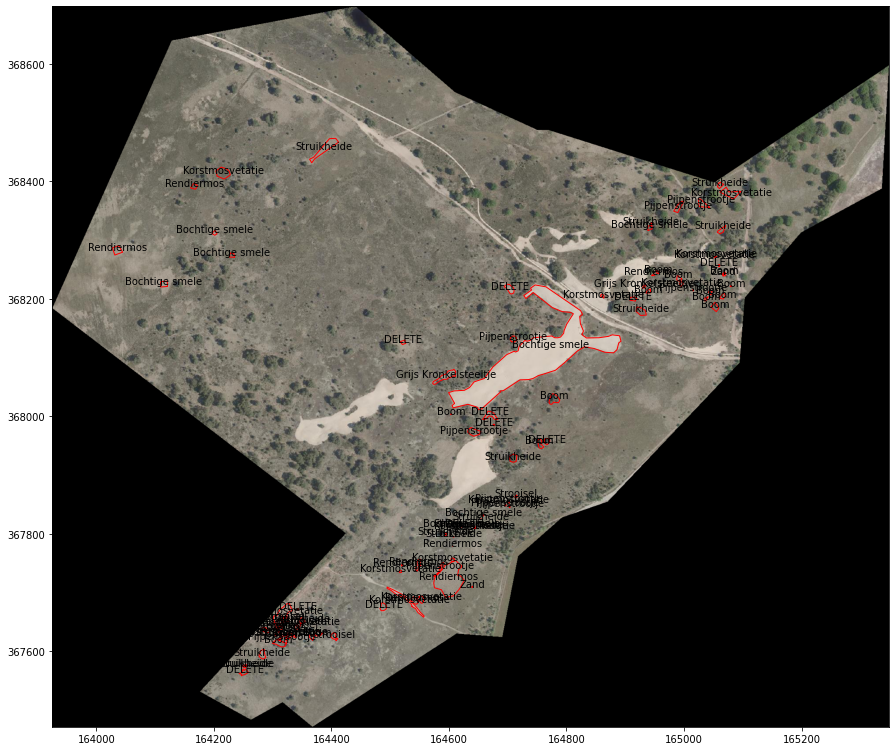

In [ ]:
######show groundtruth######
#have to import groundtruth shapefiles

groundtruth_shp='ACT_Final_Groundtruth.shp'

groundtruth = gpd.read_file(groundtruth_shp)
raster = rasterio.open("orthoHRmasked.tif")

#print groundtruth head to know the label column name
print(groundtruth.head())

#plot the rgb raster and groundtruth
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(raster, ax=ax)
groundtruth.plot(ax=ax, facecolor='none', edgecolor='red')

groundtruth['coords'] = groundtruth['geometry'].apply(lambda x: x.representative_point().coords[:])
groundtruth['coords'] = [coords[0] for coords in groundtruth['coords']]

#input column name that contains groundtruth labels
labels= 'Label'
for idx, row in groundtruth.iterrows():
    plt.annotate(s=row[labels], xy=row['coords'],
                 horizontalalignment='center')

In [ ]:
####  convert groundtruth to raster and plot ####
#the groundtruth raster could be used for validation or mapping
#for this to work the groundtruth shapefile has to have integer values representing the different classes

groundtruth = gpd.read_file(groundtruth_shp)

# Get list of geometries for all features in vector file
geom = [shapes for shapes in groundtruth.geometry]

# Open example raster
raster = rasterio.open('orthoHRmasked.tif')


# create a numeric unique value for each row
groundtruth['id'] = range(0,len(groundtruth))

groundtruth_int_label= 'type_int'
# create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = ((geom,value) for geom, value in zip(groundtruth.geometry, groundtruth[groundtruth_int_label]))

# Rasterize vector using the shape and transform of the raster
rasterized = rasterize(geom_value,
                                out_shape = raster.shape,
                                transform = raster.transform,
                                all_touched = True,
                                fill = 0,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = np.int16)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)

#output the groundtruth raster as tif file
with rasterio.open(
        'rasterized_groundtruth.tif', "w",
        driver = "GTiff",
        transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)

KeyError: ignored